# PyTorch DataSets and DataLoaders
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/fundamentals-of-deep-learning/blob/main/notebooks/9.data-loaders.ipynb)


In [1]:
import sys
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

# Figure out whether we have a GPU; if not use the CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
def plot_loss(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_loss))
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, label='val_loss')
    ax.legend(loc='upper right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")
        
def plot_accur(history, ax=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epochs")
    accur = history[:,2]
    val_accur = history[:,3]
    ax.set_ylim(0,1.05)
    ax.plot(accur, label='accur')
    ax.plot(val_accur, label='val_accur')
    ax.legend(loc='lower right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")
        
def imgrid(images, digits, dim=(5,5), figsize=(4, 4)):
    fig, axes = plt.subplots(*dim, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        img_as_row = images[i]
        img28x28 = img_as_row.reshape(28,28)
        ax.axis('off') # don't show x, y axes
        ax.imshow(img28x28, cmap='Greys')
        ax.text(0, 8, digits[i], color='#313695', fontsize=15)

## Load data

Let's use a subset of the well-known MNIST handwritten digits data set. This is like the "hello world" of image recognition for deep learning. 

In [3]:
df_mnist = pd.read_csv("https://mlbook.explained.ai/data/mnist-10k-sample.csv.zip")
X = df_mnist.drop('digit', axis=1).values # get just pixels
y = df_mnist['digit'].values              # get just digit value

In [4]:
X.shape

(10000, 784)

In [5]:
# shuffle
n = len(X)
idx = np.random.randint(0,n,n)
X = X[idx,:]
y = y[idx]

In [6]:
X.shape

(10000, 784)

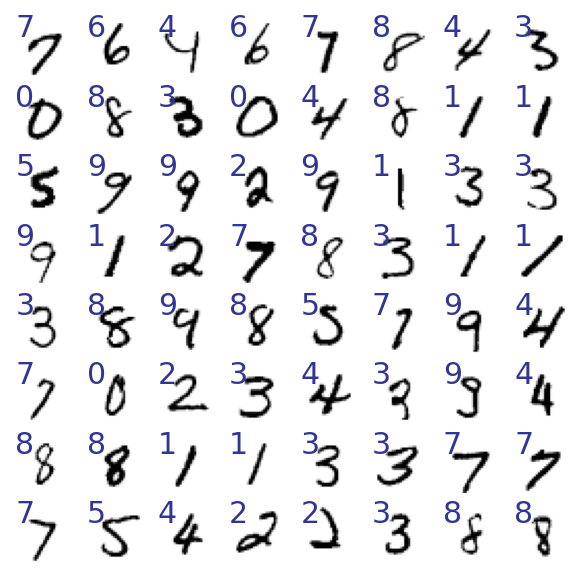

In [7]:
imgrid(X,digits=y,dim=(8,8),figsize=(5,5))

Now, let's create tensors from the X and y data; also indicate we want that data on the GPU:

In [8]:
X = torch.tensor(X).float().to(device)
y = torch.tensor(y).to(device)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Training loop using TensorDataset and DataLoader

In [13]:
def sgdtrain(model:nn.Module,
             train_data:TensorDataset, valid_data:TensorDataset, 
             learning_rate = .0001, nepochs=2000, batch_size=32):
    train_loader = DataLoader(train_data, batch_size=batch_size)
    X_train, y_train = train_data.tensors
    X_test, y_test = train_data.tensors
    nbatches = n // batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = []
    best_loss = 1e10
    best_model = None
    best_epoch = -1
    for epoch in range(nepochs+1):
        epoch_training_loss = 0.0
        for bi, (batch_X, batch_y) in enumerate(train_loader): # mini-batch
#             if len(batch_x)!=batch_size:
#                 print(f"\tBatch {bi:3d} len {len(batch_x)}")
            y_pred = model(batch_X)
            # Assume model yields softmax probabilities
            loss = F.cross_entropy(y_pred, batch_y)
            epoch_training_loss += loss.detach().item()

            optimizer.zero_grad()
            loss.backward() # autograd computes w1.grad, b1.grad, ...
            optimizer.step()

        epoch_training_loss /= nbatches # average batch loss

        # This construct is for memory efficiency and speed;
        # means to avoid doing any of the auto gradient computations
        # in this block of code
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred = torch.argmax(y_pred, axis=1)
            ncorrect = torch.sum(y_pred==y_train)
            accur = ncorrect.float() / len(y_train)

            y_test_pred = model(X_test)
            loss_test = F.cross_entropy(y_test_pred, y_test)
            y_test_pred = torch.argmax(y_test_pred, axis=1)
            ncorrect = torch.sum(y_test_pred==y_test)
            loss_accur = ncorrect.float() / len(y_test)
        
        # Save all of the computations; loss.item() detaches
        # the hidden auto gradient computation graph.
        # Gets just the value. Otherwise, this procedure
        # runs out of memory on the GPU. 
        history.append((loss.item(), loss_test, accur, loss_accur))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}")

    print(f"BEST test cross entropy loss {best_loss:.3f} at epoch {best_epoch}")
    return torch.tensor(history), best_model

## Train with SGD (batch normalization)

In [29]:
# make sure to create a new model otherwise it starts from where it left off
model = nn.Sequential(
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

model = model.to(device) # make sure the model runs on the GPU as well

In [30]:
# On the CPU, this will take a very long time so
history,_ = sgdtrain(model,
                     TensorDataset(X_train, y_train),
                     TensorDataset(X_test, y_test),
                     learning_rate = .01, nepochs=300,
                     batch_size=32
                  )

Epoch    0 cross entropy loss  1.6442   test loss  1.5309
Epoch   30 cross entropy loss  1.4926   test loss  1.4746
Epoch   60 cross entropy loss  1.4925   test loss  1.4692
Epoch   90 cross entropy loss  1.4924   test loss  1.4695
Epoch  120 cross entropy loss  1.4924   test loss  1.4697
Epoch  150 cross entropy loss  1.4924   test loss  1.4700
Epoch  180 cross entropy loss  1.4924   test loss  1.4708
Epoch  210 cross entropy loss  1.4924   test loss  1.4681
Epoch  240 cross entropy loss  1.4924   test loss  1.4679
Epoch  270 cross entropy loss  1.4924   test loss  1.4682
Epoch  300 cross entropy loss  1.4924   test loss  1.4682
BEST test cross entropy loss 1.467 at epoch 196


In [31]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.993


In [32]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.973


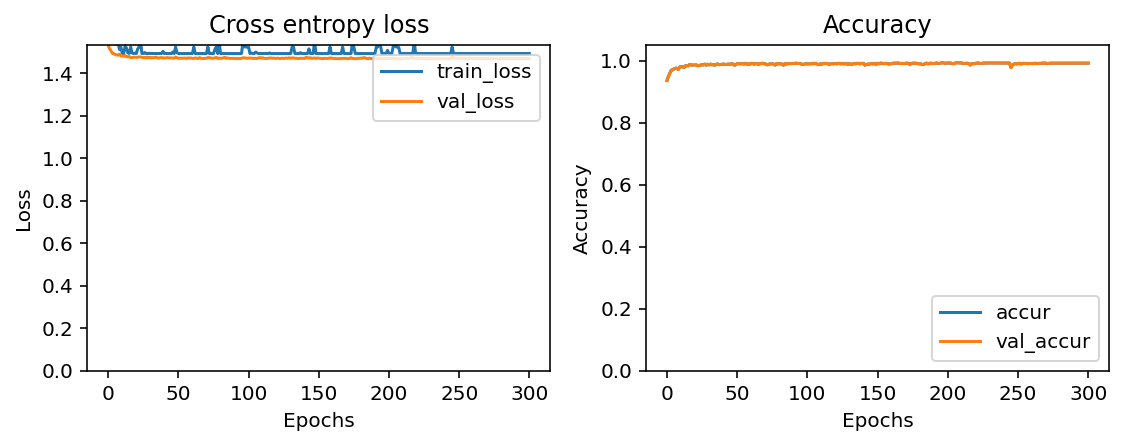

In [33]:
fig, axes = plt.subplots(1,2, figsize=(8,3))
plot_loss(history, ax=axes[0])
plot_accur(history, ax=axes[1])
axes[0].set_title("Cross entropy loss")
axes[1].set_title("Accuracy")
plt.show()